<a href="https://colab.research.google.com/github/Aswani-ReddyKV/Capstone_Sentiment_Recommendation/blob/main/Aswani_Reddy_Sentiment_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
# install required packages
# !pip install -q openai langchain chromadb faiss-cpu PyPDF tiktoken docarray langchain-openai langchain-community

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

In [3]:
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 2)

In [4]:
%matplotlib inline

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Define the path where all files are present on google drive
folder_path = '/content/drive/MyDrive/Colab Notebooks/Course_6_GenAI/Sentiment_Analysis/'

# **Loading Dataset**



In [7]:
# importing dataset
df_reviews = pd.read_csv(folder_path+"sample30.csv")
df_reviews.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [11]:
metadata = pd.read_csv(folder_path+"Data+Attribute+Description.csv",  encoding='latin1')
metadata

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product in the dataset
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


# **Exploratory Data Analysis**



In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

###Get the unique value count for each column###

In [12]:
df_reviews.nunique()

,0
id,271
brand,214
categories,270
manufacturer,227
name,271
reviews_date,6857
reviews_didPurchase,2
reviews_doRecommend,2
reviews_rating,5
reviews_text,27282


In [13]:
# Calculates the percentage of missing values in each column of a DataFrame.
# Args:
#   X (pandas.DataFrame): The input DataFrame.
# Returns:
#   pandas.DataFrame: A DataFrame containing the percentage of missing values for each column, sorted in descending order.
def get_missing_value_percentage(X):
  percent_missing = round((X.isnull().sum() / X.isnull().count()*100),3).to_frame('missing_percentage').sort_values('missing_percentage',ascending = False)
  return percent_missing

In [14]:
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_userProvince,9.94e+01
reviews_userCity,9.36e+01
reviews_didPurchase,4.69e+01
reviews_doRecommend,8.57e+00
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
brand,0.00e+00


#### ***Observatoins*** ####

Here are the key takeways from the above results:
* Thare are 30000 rows
* Total of 271 unique products
* Total Categories - 270
* Thare are 24914 users
* Three fields are there in the dataset which are having more than 40% of missing values(reviews_userProvince, reviews_userCity, reviews_didPurchase)

####Drop the columns with more than 40% of missing values####

In [15]:
df_reviews.drop(columns=["reviews_userProvince", "reviews_userCity", "reviews_didPurchase"],inplace=True)
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_doRecommend,8.57e+00
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
name,0.00e+00


In [16]:
round(df_reviews[["reviews_doRecommend"]].value_counts(normalize=True) * 100, 2)

,proportion
reviews_doRecommend,
True,94.35
False,5.65


In [17]:
df_reviews = df_reviews.drop(columns=['reviews_doRecommend'])
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
name,0.00e+00
reviews_rating,0.00e+00


In [19]:
df_reviews['reviews_title'].fillna('unknown',inplace=True)
df_reviews['reviews_username'].fillna('unknown',inplace=True)
df_reviews['manufacturer'].fillna('unknown',inplace=True)
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
categories,0.00e+00
brand,0.00e+00
name,0.00e+00
manufacturer,0.00e+00
reviews_rating,0.00e+00
reviews_text,0.00e+00
reviews_title,0.00e+00


In [20]:
df_reviews = df_reviews[~ df_reviews['reviews_date'].isna()]
get_missing_value_percentage(df_reviews)

,missing_percentage
user_sentiment,3.00e-03
brand,0.00e+00
id,0.00e+00
categories,0.00e+00
manufacturer,0.00e+00
reviews_date,0.00e+00
name,0.00e+00
reviews_rating,0.00e+00
reviews_text,0.00e+00
reviews_title,0.00e+00


In [21]:
round(df_reviews[["user_sentiment"]].value_counts(normalize=True) * 100, 2)

,proportion
user_sentiment,
Positive,88.79
Negative,11.21


In [22]:
df_reviews['user_sentiment'].fillna('Positive', inplace=True)
get_missing_value_percentage(df_reviews)

,missing_percentage
id,0.0
brand,0.0
categories,0.0
manufacturer,0.0
name,0.0
reviews_date,0.0
reviews_rating,0.0
reviews_text,0.0
reviews_title,0.0
reviews_username,0.0


In [23]:
# mapping positive to 1 and negative to 0
df_reviews['user_sentiment']=df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})

In [24]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29954 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29954 non-null  object
 1   brand             29954 non-null  object
 2   categories        29954 non-null  object
 3   manufacturer      29954 non-null  object
 4   name              29954 non-null  object
 5   reviews_date      29954 non-null  object
 6   reviews_rating    29954 non-null  int64 
 7   reviews_text      29954 non-null  object
 8   reviews_title     29954 non-null  object
 9   reviews_username  29954 non-null  object
 10  user_sentiment    29954 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 2.7+ MB


In [26]:
df_reviews.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0


Text(0.5, 1.0, 'Frequency distribution of reviews_rating')

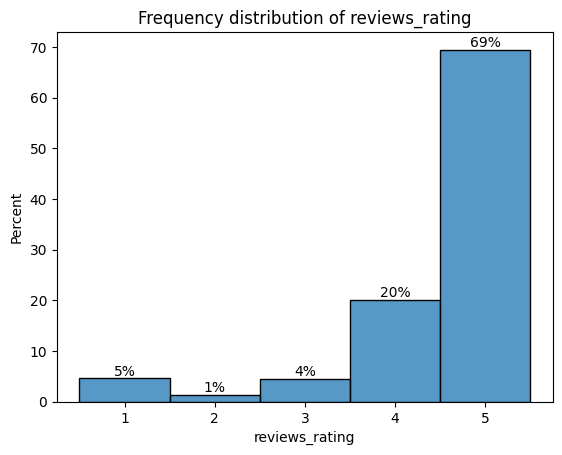

In [28]:
# Frequency plot of reviews_rating column
ax=sns.histplot(df_reviews['reviews_rating'],stat='percent',discrete='bool')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
plt.title("Frequency distribution of reviews_rating")

Text(0.5, 1.0, 'Class imbalance of sentiment')

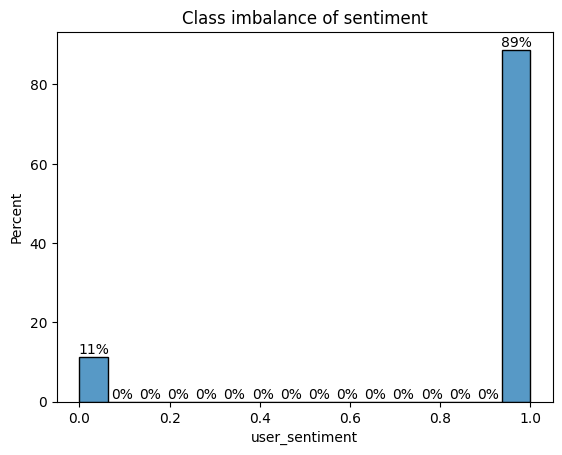

In [29]:
# Class imbalance
ax=sns.histplot(df_reviews['user_sentiment'],stat='percent')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
plt.title("Class imbalance of sentiment")
# There is class imbalance as we can see that 88% of data has positive reviews.